### Integrantes del grupo
* Carlos Madrid Urbano
* Alejandro Pérez Sanjuán

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.datasets import load_sample_images
from skimage.metrics import peak_signal_noise_ratio
from skimage.data import astronaut, coffee, cat, rocket, binary_blobs, brain, clock
from utils import (
    add_noise,
    get_sketch,
    mean_filter,
    median_filter,
    add_salt_pepper,
    adaptive_median_filter,
    fourier_transform_denoising,
)

from utils import (
    thresholding,
    dilate,
    erosion,
    opening,
    closing
)

In [2]:
# ignore Numba warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = load_sample_images()
building, flower = dataset['images'][0], dataset['images'][1]
images = [astronaut(), coffee(), cat(), rocket(), building, flower]

## Introducción
En este documento se presenta una breve review de diferentes filtros espaciales utilizados en procesamiento de imagen.

Algunos se han implementado desde cero, e incluyen un property de jit compiling para que funcionen de forma óptima. Otros se han tomado de la librería Skimage.

En el último apartado se presenta una combinación de técnicas para `sketchizar` una imagen.

## Filtros espaciales
Hemos encontrado dos papers de review/survey que sumarizan los filtros más comunes utilizados en el campo del procesamiento de imagenes. En general, se mencionan dos tipos de ruidos:

* Sal y pimienta
* Ruido gausiano

Para el ruido `sal y pimienta` se suelen considerar filtros espaciales como los descritos a continuación:
* **Filtro de media.** El píxel considerado se sustituye por la media de sus vecinos. La operación se aplica en ventana deslizante.
* **Filtro de mediana.** El píxel considerado se sustituye por la mediana de sus vecinos. La operación se aplica en ventana deslizante.
* Filtro de mediana adaptativo.
* **Gaussian smoothing.** Aplica una operación de convolución con un kernel gausiano para eliminar ruido. Como contrapartida, el Kernel también elimina detalles.
* Convervative filter
* **Filtros de frecuencia.** La transformada de Fourier es un ejemplo. Se llevan los datos de las imágenes al dominio frecuencial y se eliminan las frecuencias considerando un sesgo. Posteriormente, se aplica la transformada inversa de Fourier para volver al espacio inicial.

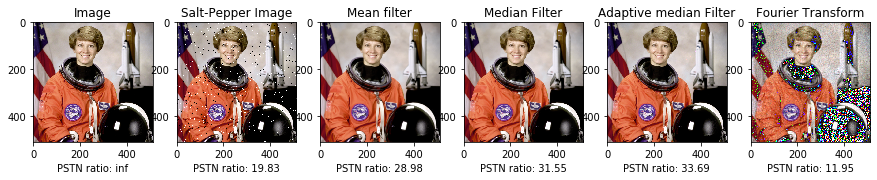

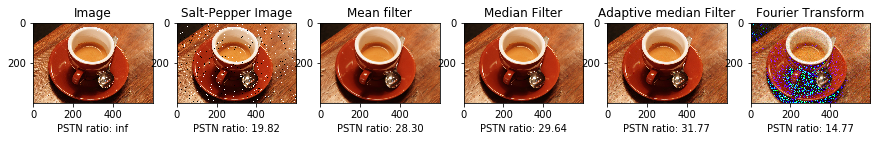

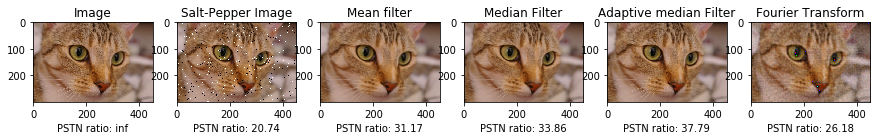

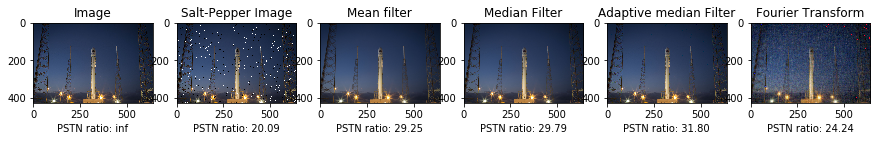

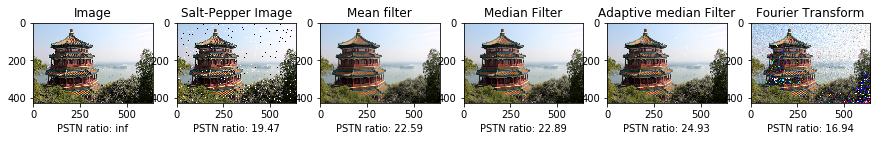

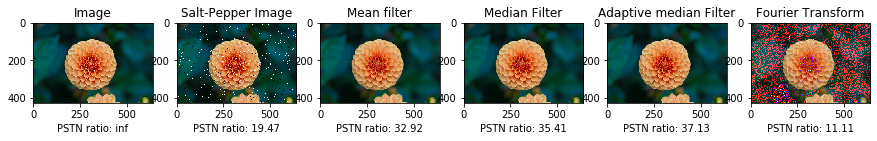

In [4]:
for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))
    
    noisy = add_salt_pepper(image=img, prob=0.03)
    
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].set_xlabel(f'PSTN ratio: inf')
    
    ax[1].imshow(noisy)
    ax[1].set_title('Salt-Pepper Image')
    ax[1].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=noisy):0.2f}")
    
    mean = mean_filter(img)
    ax[2].imshow(mean)
    ax[2].set_title('Mean filter')
    ax[2].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=mean):0.2f}")
    
    median = median_filter(noisy)
    ax[3].imshow(median)
    ax[3].set_title('Median Filter')
    ax[3].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=median):0.2f}")
    
    ad_median = adaptive_median_filter(noisy)
    ax[4].imshow(ad_median)
    ax[4].set_title('Adaptive median Filter')
    ax[4].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=ad_median):0.2f}")
    
    fft = fourier_transform_denoising(noisy, n_components=1000)
    ax[5].imshow(fft)
    ax[5].set_title('Fourier Transform')
    ax[5].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=fft):0.2f}")
    
    plt.show()

Tanto el filtro de media como el filtro de mediana eliminan la anomalía de sal y pimienta. El filtro de mediana es ligeramente superior por ser la media un estimador no robusto. Como contrapartida, la nitidez de la imagen se ver reducida; es por ello que se ha implementado un filtro de mediana adaptativo que reduce ligeramente la pérdida de información.

Por otro lado, el uso de la transformada de Fourier resulta en una pérdida de información en la mayoría de las imágenes. Incluso se puede observar la creación de artefactos nuevos que antes no se encontraban en la imagen con la anomalía.

## Operaciones morfológicas

Por lo general, la literatura menciona las siguientes operaciones morfológicas:

* **Dilatación** Cada píxel $(i,j)$ se sustituye por el máximo de los píxeles vecinos centrados en $(i,j)$
* **Erosión** Cada píxel $(i,j)$ se sustituye por el mínimo de los píxeles vecinos centrados en $(i,j)$
* **Apertura** operación de erosión seguida de operación de dilatación.
* **Cierre** operación de dilatación seguida de operación de erosión.

In [5]:
import skimage
from skimage import data, filters


images = [data.page(), data.coins(), data.camera(), data.brick(), data.grass()]

Tomaremos imágenes en blanco y negro para simplificar el proceso. En caso de ser RGB, se aplicaría sobre cada canal.

Como elemento estructural se usará un disco de tamaño pequeño. Cuanto más grande sea el disco, más impacto tendrá en la imagen.

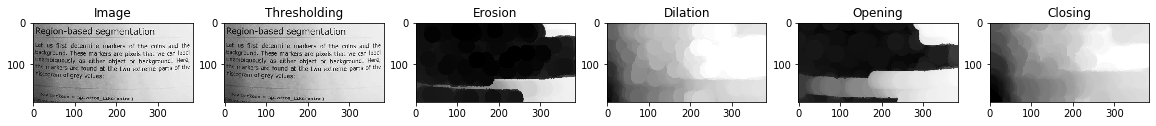

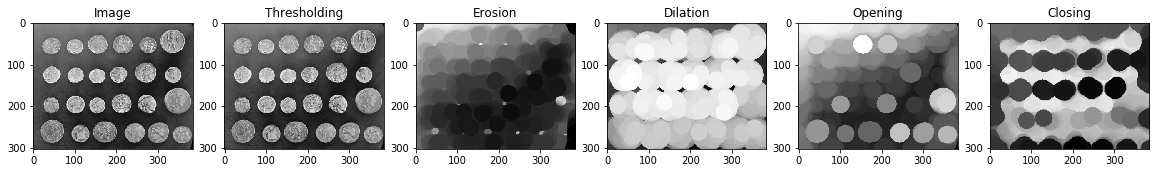

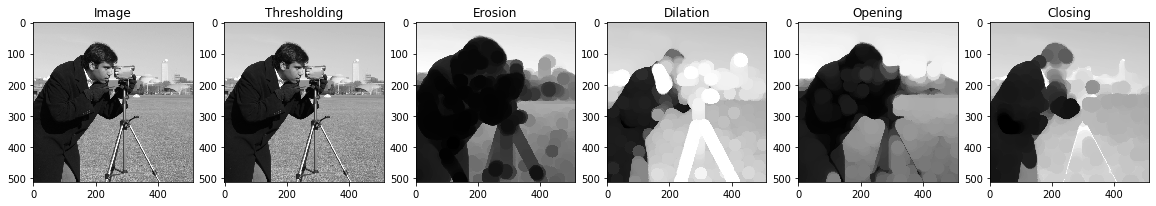

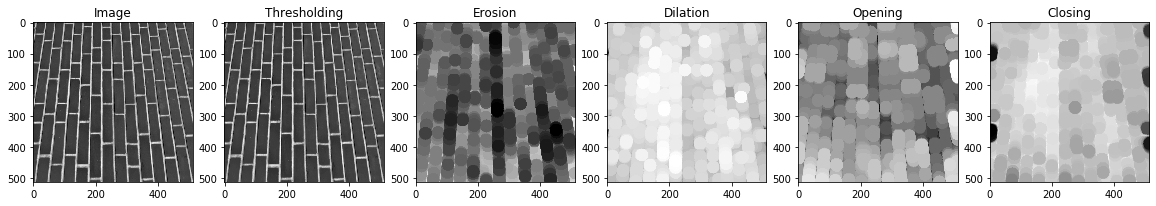

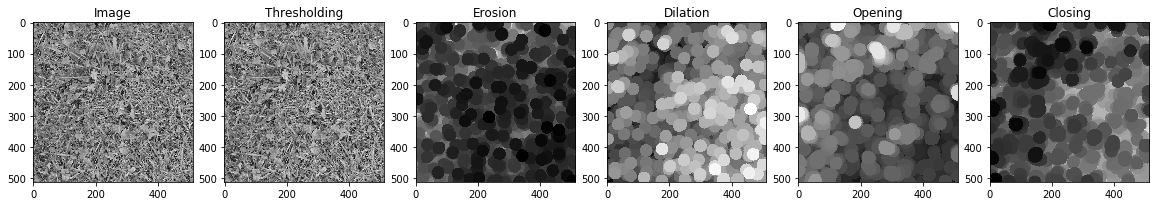

In [6]:
disk_size = 20

for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20,25))
    
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Image')
    
    th = np.clip(filters.threshold_local(img, block_size=3), 0, 255).astype('uint8')
    ax[1].imshow(th, cmap='gray')
    ax[1].set_title('Thresholding')
    
    _erosion = skimage.morphology.erosion(img, selem=skimage.morphology.disk(disk_size))
    ax[2].imshow(_erosion, cmap='gray')
    ax[2].set_title('Erosion')
    
    
    _dilation = skimage.morphology.dilation(img, selem=skimage.morphology.disk(disk_size))
    ax[3].imshow(_dilation, cmap='gray')
    ax[3].set_title('Dilation')
    
    _opening = skimage.morphology.opening(img, selem=skimage.morphology.disk(disk_size))
    ax[4].imshow(_opening, cmap='gray')
    ax[4].set_title('Opening')
    
    _closing = skimage.morphology.closing(img, selem=skimage.morphology.disk(disk_size))
    ax[5].imshow(_closing, cmap='gray')
    ax[5].set_title('Closing')

    plt.show()

## Propuesta de filtro: sketching effect
A continuación, se propone una combinación de técnicas para aplicar un estilo *sketch* a una imagen dada. 

En primer lugar se aplica un filtro gaussiano para emborronar la imagen. El filtro funciona mediante una operación de convolución.

Para detectar los bordes se utiliza el algoritmo de `Canny`, que generalmente consta de 5 pasos:
* **Reducción de ruido:** normalmente se usa un filtro gaussiano para suavizar la imagen.

* **Cálculo de gradiente:** detecta la intensidad y dirección de los bordes.

* **Supresión:** se reduce el grosor de los bordes.

* **Umbralización:** mediante un doble umbral, se identifican píxels fuertes (alta intensidad) y píxeles débiles (baja intensidad). Existe un tercer conjunto de píxels que se considera no relevante para los bordes.

* **Tratamiento de bordes:** los píxeles débiles se transforman en píxels fuertes mediante un proceso llamado histéresis.

Finalmente, la función `get_sketch` multiplica los bordes por la imagen filtrada (gaussian filter) y realiza una operación clip para mantener los vlaores en el intervalo [0,1] (o [0, 255])

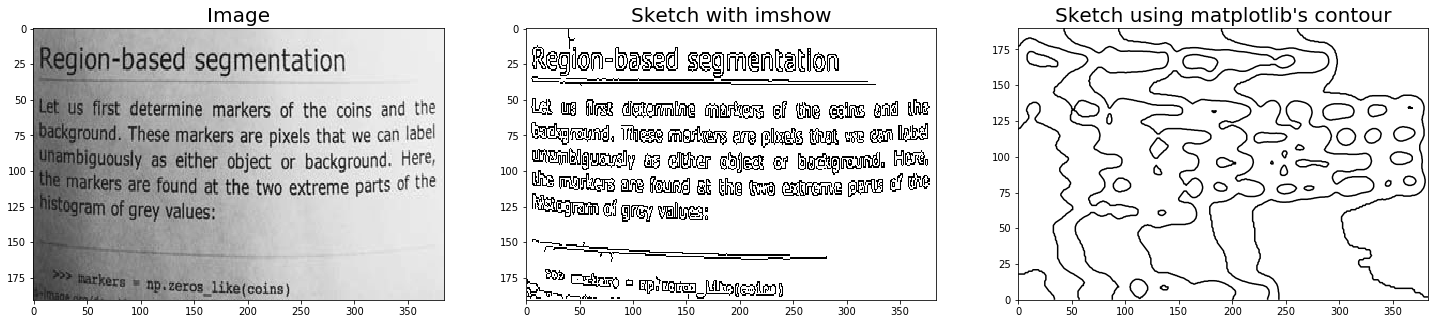

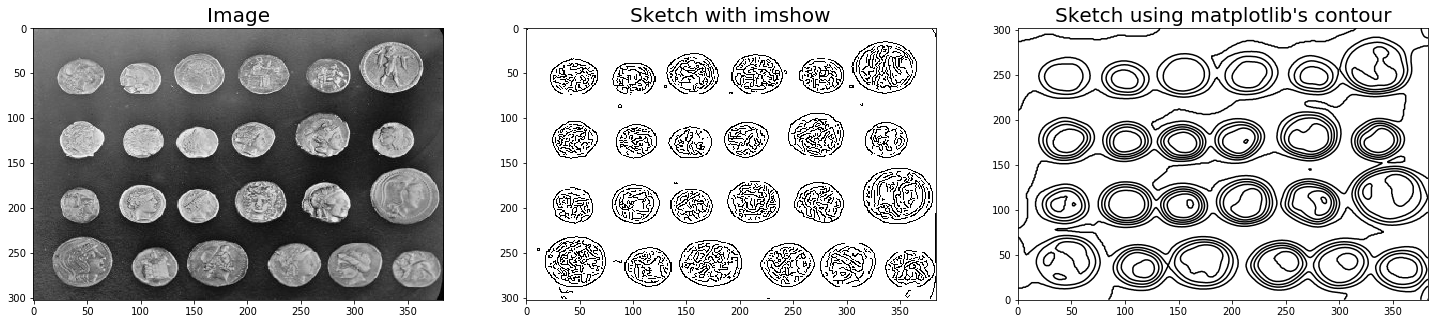

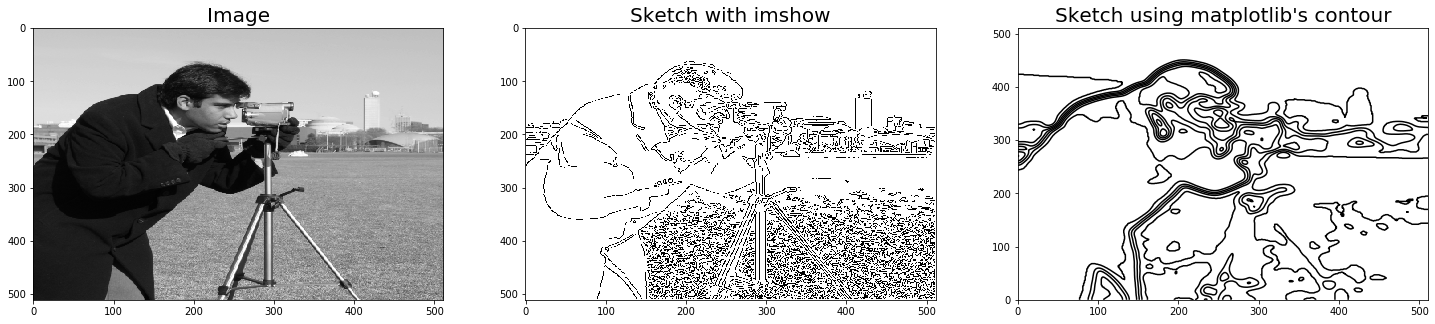

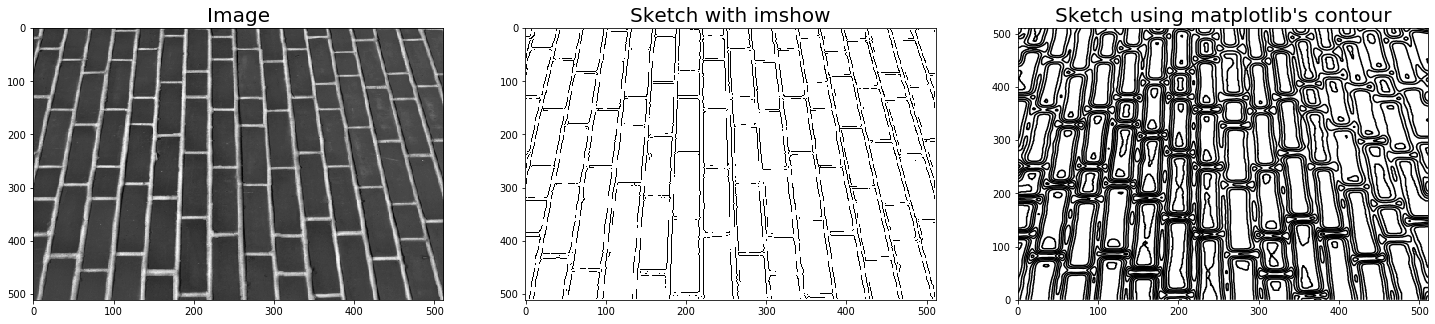

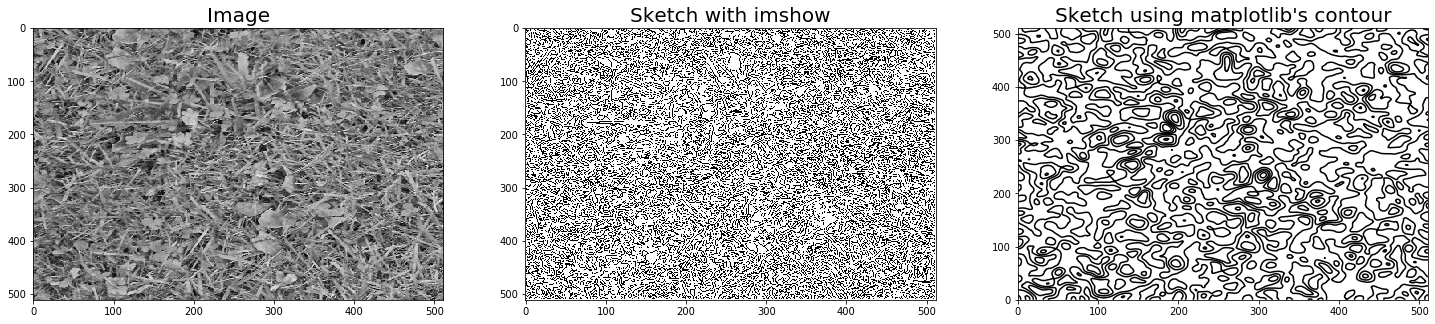

In [7]:
for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    
    blurred = ndimage.gaussian_filter(img, 5)
    #dilated = skimage.morphology.dilation(img, selem=skimage.morphology.disk(20))
    
    canny = skimage.feature.canny(img, 0.8)
    sketch = get_sketch(img=blurred, contour=canny)
    
    ax[0].imshow(img, cmap='gray', aspect="auto")
    ax[0].set_title('Image', fontsize=20)
    
    ax[1].imshow(1 - sketch, cmap='gray', aspect="auto")
    ax[1].set_title('Sketch with imshow', fontsize=20)
    
    ax[2].contour(np.flipud(blurred), colors='k')
    ax[2].set_title("Sketch using matplotlib's contour", fontsize=20)

Como extra, se ha añadido una columna de imágenes que hacen uso de la función `countour` de matplotlib. LA función permite representar valores $(x,y)$ teniendo en cuenta $z$ como nivel de "countour".

En este caso, se ha utilizado directamente la imagen emborronada con el filtro gausiano. El resultado es muy llamativo por su nitidez y por generar un dibujo de estilo abstracto.

## Conclusión
En este documente se han visto tanto filtros espaciales como operaciones morfológicas aplicas al procesamiento de imágenes.

Se ha observado que algoritmos simples tienen resultados razonablemente satisfactorios, como el filtro de mediana y su versión adaptativa. Además ...


Por último, se ha propuesto una combinación de filtro espacial y operaciones morfológicas para crear un efecto sketch. Asimismo, se ha hecho uso de las abstracciones nativas de matplotlib para crear imágenes más artíticas.

## Referencias:
* [Image Filtering Algorithms and Techniques: a review](https://www.researchgate.net/profile/Gaurav-Gupta-53/publication/325681876_Image_Filtering_Algorithms_and_Techniques_A_Review/links/5b1e1ab0aca272021cf585c9/Image-Filtering-Algorithms-and-Techniques-A-Review.pdf)

* [Analysis of color image filtering methods](https://www.researchgate.net/profile/Ziad-Alqadi/publication/319815286_Analysis_of_Color_Image_Filtering_Methods/links/59bcfa52aca272aff2d9d86b/Analysis-of-Color-Image-Filtering-Methods.pdf)

* [Digital Image Filtering Techniques- A survey](https://www.researchgate.net/publication/324985754_Digital_Image_Filtering_Techniques-_A_survey)

* [Morphological filtering for image enhacement and feature detection](http://cvsp.cs.ntua.gr/publications/jpubl+bchap/Maragos_MFIEFD_ImVidHbook2_chap3-3_AcadPress2005.pdf)

* [Canny Edge Detection Step by Step in Python — Computer Vision](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

* Jean Serra, Luc Vincent - An Overview of Morphological Filtering.